## **0-Installing Mediapipe**

In [1]:
%%capture
!pip install mediapipe

## **1- Importing Required Libraries**

In [3]:
from zipfile import ZipFile
from urllib import request
import requests
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
#from google.colab.patches import cv2_imshow

## **2- Reading Data**

In [4]:
file_link="http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip"
file_name="AFLW2000-3D.zip"

#response=request.urlretrieve(file_link,filename=file_name)

with ZipFile("AFLW2000-3D.zip",'r') as zip:
  zip.printdir()
  zip.extractall()


File Name                                             Modified             Size
AFLW2000/                                      2016-03-29 22:52:46            0
AFLW2000/Code/                                 2016-03-29 23:02:26            0
AFLW2000/Code/DrawSolidHead.m                  2016-03-29 22:52:42         1457
AFLW2000/Code/DrawTextureHead.m                2016-03-29 22:52:42          469
AFLW2000/Code/main_show_without_BFM.m          2016-03-29 23:04:16          291
AFLW2000/Code/main_show_with_BFM.m             2016-03-29 23:02:04         2437
AFLW2000/Code/Mex/                             2016-03-29 22:52:42            0
AFLW2000/Code/Mex/compile.m                    2016-03-29 22:52:42           36
AFLW2000/Code/Mex/Tnorm_Vnorm.h                2016-03-29 22:52:42          456
AFLW2000/Code/Mex/Tnorm_VnormC.cpp             2016-03-29 22:52:42          496
AFLW2000/Code/Mex/Tnorm_VnormC.mexw64          2016-03-29 22:52:42         7168
AFLW2000/Code/ModelGeneration/          

From looking at the data we can note that each image exists as a .jpg file and a .mat (MATLAB) file.

We need to separate them into 2 lists.


In [7]:
#we use the glob module that returns all files that follow a pattern to separate files
jpg_files=glob.glob("AFLW2000/*.jpg")
jpg_files.sort()
mat_files=glob.glob("AFLW2000/*.mat")
mat_files.sort()
print(f"we have {len(jpg_files)} jpg files, and {len(mat_files)} mat files.")

we have 2000 jpg files, and 2000 mat files.


## **3- Exploring Data & Helper Functions**

Image shape:  (450, 450, 3)


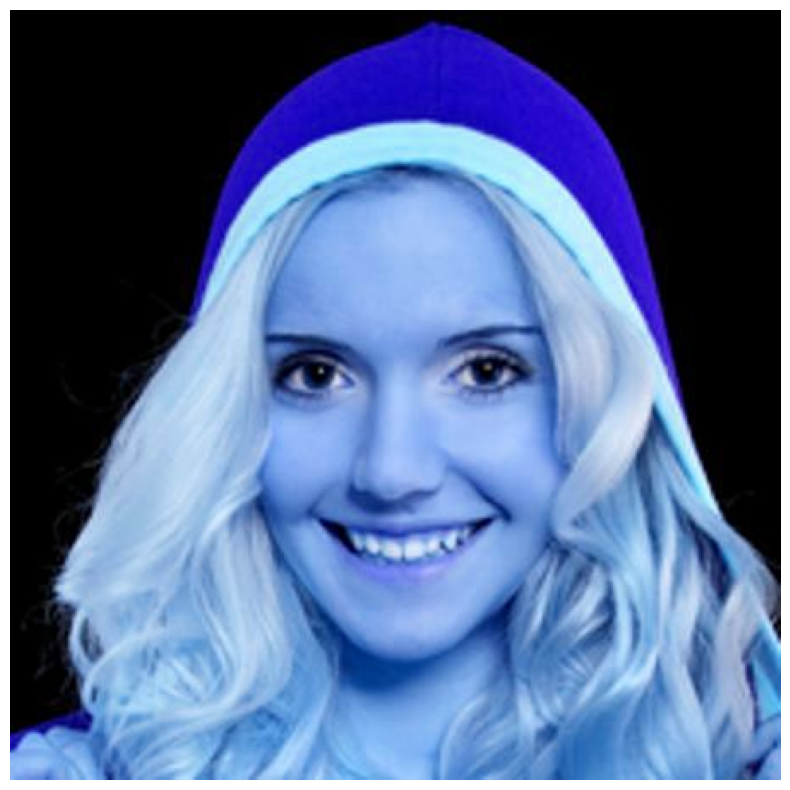

In [10]:
img = cv2.imread(jpg_files[686])
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img); 

It can be noted that the colors are not right. 
That is because cv2 reads the color channel as BGR not RGB. Thus to plot it correctly we will need to turn them into RGB.

Image shape:  (450, 450, 3)


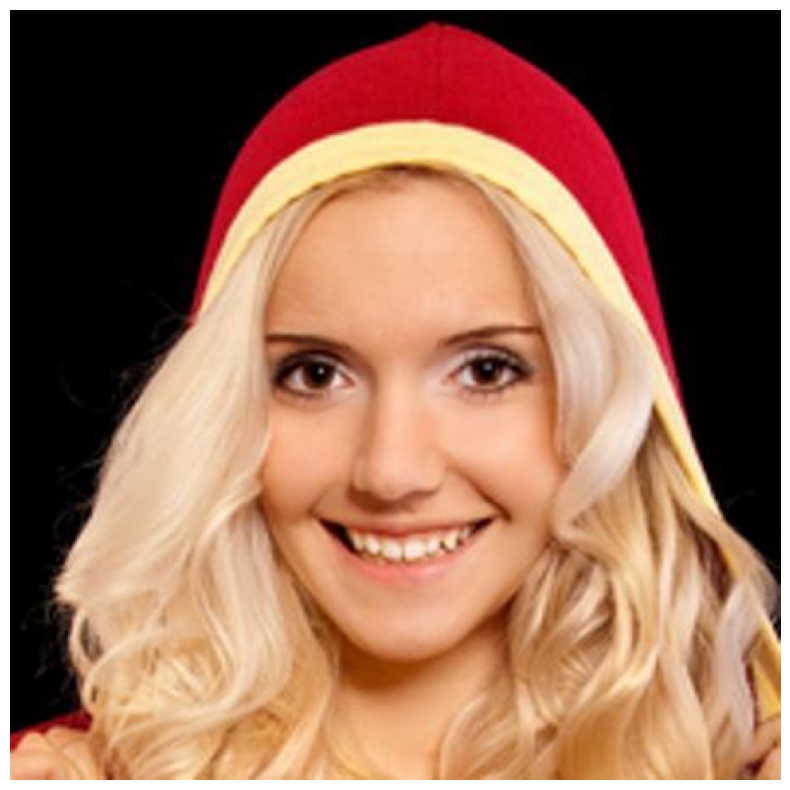

In [11]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

In [12]:
print(mat_files[10],jpg_files[10])

AFLW2000\image00022.mat AFLW2000\image00022.jpg


# 4- Important Functions

In [13]:
def extract_features(img,facemesh, mat=None):

  NOSE = 1
  FOREHEAD = 10
  LEFT_EYE = 33
  MOUTH_LEFT = 61
  CHIN = 199
  RIGHT_EYE = 263
  MOUTH_RIGHT = 291

  result = facemesh.process(img)
  face_features = []

  if result.multi_face_landmarks != None:
      for face_landmarks in result.multi_face_landmarks:
          for idx, lm in enumerate(face_landmarks.landmark):
              if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                  face_features.append(lm.x)
                  face_features.append(lm.y)
  else:
      face_features.extend([None] * 14)
  
  if mat:
      pose_angles = mat['Pose_Para'][0][:3]
      face_features.extend(pose_angles)
      
  return face_features

In [14]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 50):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(255,0,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(0,0,255),2)

    return img

## **5- Data Creation**

In [15]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)
cols.extend(['pitch', 'yaw', 'roll'])

In [16]:
all_features=[]
facemesh=mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
for i in range(len(mat_files)):
  img = cv2.imread(jpg_files[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mat = sio.loadmat(mat_files[i])
  features=extract_features(img,facemesh,mat)
  all_features.append(features)

data_df=pd.DataFrame(all_features,columns=cols)

In [17]:
data_df.head()

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374


## **6- Data Cleaning**

In [18]:
data_df.isna().sum(axis=1)

0        0
1        0
2        0
3        0
4        0
        ..
1995     0
1996    14
1997    14
1998    14
1999     0
Length: 2000, dtype: int64

In [19]:
#deleting rows with null values
clean_df=data_df.dropna()
clean_df.isna().sum(axis=1)

0       0
1       0
2       0
3       0
4       0
       ..
1991    0
1992    0
1994    0
1995    0
1999    0
Length: 1792, dtype: int64

# 7- Data Normalization

In [20]:
def normalize(poses_df):
    normalized_df = poses_df.copy()
    
    for dim in ['x', 'y']:
        # Centerning around the nose 
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]
        
        
        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff
    
    return normalized_df

In [21]:
normalized_df=normalize(clean_df)
normalized_df.head()

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.0,0.0,0.145389,-1.315685,-0.612647,-0.757945,-0.389327,0.157636,-0.035876,0.643461,0.821789,-0.634208,0.387353,0.242055,-0.399231,0.018227,0.085676
1,0.0,0.0,0.643168,-1.238742,0.061645,-0.584067,0.174874,0.306017,0.400586,0.764764,1.780222,-0.463914,1.061645,0.415933,0.470065,1.189533,0.300959
2,0.0,0.0,-0.012524,-1.450241,-0.134608,-0.661405,0.217967,0.362334,0.524888,0.861074,0.886842,-0.706921,0.865392,0.338595,-0.184650,0.881137,-0.236852
3,0.0,0.0,-0.239980,-1.951528,-0.454436,-0.874364,-0.017618,0.357641,0.334972,0.924901,0.547998,-1.273491,0.545564,0.125636,-0.175379,0.299208,-0.373374
4,0.0,0.0,0.206458,-1.236728,0.227247,-0.580952,0.552568,0.414430,0.860054,0.827818,1.380055,-0.666052,1.227247,0.419048,-0.882169,1.198004,-1.033374


## **8- Splitting Data**

In [22]:
from sklearn.model_selection import train_test_split
y=normalized_df[['pitch','yaw','roll']]
x=normalized_df.drop(['pitch','yaw','roll'],axis=1)
x_train,x_test,y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1344, 14) (1344, 3) (448, 14) (448, 3)


## **9- Model Training**

In [23]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.metrics import mean_squared_error

param_grid = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': scipy.stats.expon(scale=5),
    'estimator__degree': np.arange(2, 6),
    'estimator__coef0': np.arange(0, 6),
    'estimator__gamma': scipy.stats.expon(scale=.1),
    'estimator__epsilon': scipy.stats.expon(scale=.1)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(x_train, y_train)
svr_model = random_search.best_estimator_
print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_test, svr_model.predict(x_test))))


best parameters:  {'estimator__C': 2.3463404498842957, 'estimator__coef0': 4, 'estimator__degree': 4, 'estimator__epsilon': 0.13167456935454494, 'estimator__gamma': 0.09129425537759533, 'estimator__kernel': 'rbf'}
train_rmse:  0.21938216333563565
validation_rmse:  0.2227355287416287


In [24]:
svr_model

MultiOutputRegressor(estimator=SVR(C=2.3463404498842957, coef0=4, degree=4,
                                   epsilon=0.13167456935454494,
                                   gamma=0.09129425537759533))

Creating video output

In [29]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(r'WIN_20230220_23_43_18_Pro.mp4')  # From Camera
video_width=int(cap.get(3))
video_height=int(cap.get(4))
size=(video_width,video_height)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(r'output.mp4', fourcc, 20, size)

while(cap.isOpened()):

    # Take each frame
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        img_h, img_w, img_c = img.shape
        text = ''
        
        
        face_features = extract_features(img, face_mesh)
        if len(face_features):
            face_features_df = pd.DataFrame([face_features], columns=cols[0:14])
            face_features_normalized = normalize(face_features_df)
            pitch_pred, yaw_pred, roll_pred = svr_model.predict(face_features_normalized).ravel()
            nose_x = face_features_df['nose_x'].values * img_w
            nose_y = face_features_df['nose_y'].values * img_h
            img = draw_axis(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
                        
            if pitch_pred > 0.3:
                text = 'Top'
                if yaw_pred > 0.3:
                    text = 'Top Left'
                elif yaw_pred < -0.3:
                    text = 'Top Right'
            elif pitch_pred < -0.3:
                text = 'Bottom'
                if yaw_pred > 0.3:
                    text = 'Bottom Left'
                elif yaw_pred < -0.3:
                    text = 'Bottom Right'
            elif yaw_pred > 0.3:
                text = 'Left'
            elif yaw_pred < -0.3:
                text = 'Right'
            else:
                text = 'Forward'
                
        cv2.putText(img, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img)
        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break
    else:
        break

out.release()
cv2.destroyAllWindows()